In [31]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import random
import time
import joblib
import os
from utils import render_single, render_multiple, get_dataset_files, extract_random_entries, extract_first_entries, generate_pixel_columns, load_run, extract_best_entries
from IPython.display import display, Image as IPImage

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
load_existing_run = None

if load_existing_run is None:
    num_cats = 5
    entries_per_cat = 5000
    image_gen_params = {
        'magnification': 4,
        'resolution': 64,
        'invert_color': True,
        'stroke_width_scale': 3
    }
    
    # files = get_dataset_files()
    # files = random.sample(files, num_cats)
    files = ['./dataset/clock.ndjson', './dataset/bicycle.ndjson', './dataset/sailboat.ndjson', './dataset/house.ndjson', './dataset/car.ndjson']
    # data = [extract_first_entries(file, entries_per_cat, recognized=True) for file in files]
    # flat_data = [item for sublist in data for item in sublist]
    # df_loaded = pd.DataFrame.from_dict(flat_data, orient='columns')
    # print(f'Loaded {len(df_loaded)} entries from {files}')
    # df = df_loaded.sample(len(df_loaded))
    # print('Done shuffling dataset')
    files = ['./dataset/car.ndjson', './dataset/bicycle.ndjson']
    df = pd.concat([extract_best_entries(file, 5000, recognized=True) for file in files], ignore_index=True).sort_values(by='complexity')
    print(f'Loaded {len(df)} entries from {files}')
    df = generate_pixel_columns(df, **image_gen_params)
    print('Done generating pixel columns')
    df = df.reset_index(drop=True)

else:
    run = load_run(load_existing_run)
    df = run['data']
    num_cats = len(df['word'].value_counts())
    entries_per_cat = df['word'].value_counts()[df['word'].value_counts().keys()[0]]
    image_gen_params = run['img_params']
    

Loaded 10000 entries from ['./dataset/car.ndjson', './dataset/bicycle.ndjson']
Done generating pixel columns


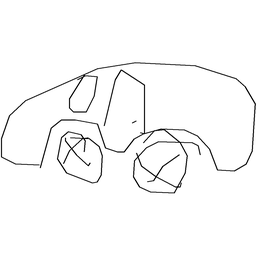

car


In [33]:
img = df.sample().iloc[0]
display(IPImage(render_single(img['drawing'])))
print(img['word'])

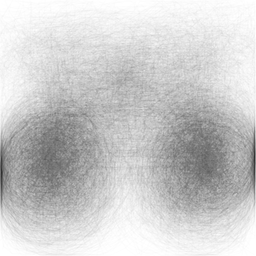

1000 superimposed bicycles.


In [34]:
count = 1000 if entries_per_cat > 1000 else entries_per_cat
word = random.choice(df['word'].values)
imgs = df[df['word'] == word].sample(count)
display(IPImage(render_multiple(imgs['drawing'])))
print(f'{count} superimposed {word}s.')

In [35]:
train_amt = int(len(df) * .9)

train = df[:train_amt]
test = df[train_amt:]
# del df

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print(f'Train: {len(train)} entries, test: {len(test)} entries.')

Train: 9000 entries, test: 1000 entries.


In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_on = True

#a numpy array is an array which is managed by C-code, and it's more efficient
y = train['word'].to_numpy()
X = train.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word']).to_numpy()
print("Done generating features and target")

#instantiate a scaler and apply PCA 
if pca_on:
    if load_existing_run is None:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        pca = PCA(.85)
        X = pca.fit_transform(X)
        print(f'PCA & standardization done. Keeping {pca.n_components_} features')
    else:
        scaler = run['scaler']
        pca = run['pca']
        X = scaler.transform(X)
        X = pca.transform(X)
        print('Applied scaler and PCA.')

save_to_disk = True

#save the data in a folder (if not exists) and save the data, pca and scaler info
if save_to_disk:
    stamp = str(int(time.time()))
    folder = f'./runs/{stamp}/'
    if not os.path.exists(folder):
        os.makedirs(folder)
    pd.DataFrame.to_feather(df, folder + 'data')
    with open(folder + 'img_params', 'w') as f:
        f.writelines(str(image_gen_params))
    print('Done saving dataset to disk')
    if pca_on:
        joblib.dump(pca, folder + 'pca')
        joblib.dump(scaler, folder + 'scaler')
        print('Done saving PCA and scaler to disk')

Done generating features and target
PCA & standardization done. Keeping 358 features
Done saving dataset to disk
Done saving PCA and scaler to disk


In [37]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from itertools import repeat

# Which class does this instance belong to?
# in a multiclass classification problem can be reduced to:
#  for each class in classes:
#    does this instance belong to class? -> probability
#  return the class with the highest probability

classifiers = {
    'LinearSVC': LinearSVC(dual=False),
    'NuSVC': NuSVC(nu=.01),
    # 'SGDClassifier': SGDClassifier(loss='epsilon_insensitive', penalty='elasticnet', n_jobs=-1),
    'SVC': SVC(kernel='rbf', C=2.5, gamma=.0001105),
    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(store_covariance=True),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(store_covariance=True),
    'MLPClassifier': MLPClassifier(hidden_layer_sizes=tuple(repeat(int(pca.n_components_ * 1.2), 3)), solver='lbfgs', alpha=1e-07),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(),
    # 'ExtraTreeClassifier': ExtraTreeClassifier(),
    # 'KernelRidge': KernelRidge(),
    # 'GaussianProcess': GaussianProcessClassifier(1.0 * RBF(1.0)),
}

models = {}
start = time.time()
for type, classifier in classifiers.items():
    models[type] = OneVsRestClassifier(classifier, n_jobs=-1).fit(X, y)
    end = time.time()
    print(f"Done training {type} model in {'{:.2f}'.format(end - start)}s")
    start = end

if save_to_disk:
    joblib.dump(models, folder + 'models')
    print("Done saving models to disk")

Done training LinearSVC model in 0.96s
Done training NuSVC model in 6.79s
Done training SVC model in 5.11s
Done training LinearDiscriminantAnalysis model in 0.66s
Done training QuadraticDiscriminantAnalysis model in 0.63s
Done training MLPClassifier model in 21.93s
Done training KernelRidge model in 6.57s
Done saving models to disk


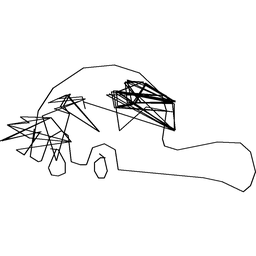

Using MLPClassifier classifier
car(predicted) == car(actual) ? True


In [38]:
import random
cls_type, model = random.choice(list(models.items()))
# model = models['SVC']

sample = test.sample(1)
sample_predict = sample.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word']).to_numpy()

if pca_on:
    sample_predict = scaler.transform(sample_predict)
    sample_predict = pca.transform(sample_predict)

prediction = model.predict(sample_predict)
display(IPImage(render_single(sample['drawing'].iloc[0])))
print(f"Using {cls_type} classifier")
print(f"{prediction[0]}(predicted) == {sample['word'].iloc[0]}(actual) ? {sample['word'].iloc[0] == prediction[0]}")

In [39]:
for model_type, model in models.items():
    test2 = test.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word']).to_numpy()
    if pca_on:
        test2 = scaler.transform(test2)
        test2 = pca.transform(test2)
    prediction = model.predict(test2)

    from sklearn.metrics import accuracy_score
    acc_score = accuracy_score(test['word'].values.tolist(), prediction)
    print(f"{model_type} classifier, accuracy: {acc_score}")

LinearSVC classifier, accuracy: 0.878
NuSVC classifier, accuracy: 0.952
SVC classifier, accuracy: 0.933
LinearDiscriminantAnalysis classifier, accuracy: 0.883
QuadraticDiscriminantAnalysis classifier, accuracy: 0.903
MLPClassifier classifier, accuracy: 0.93
KernelRidge classifier, accuracy: 0.617


LinearSVC classifier, accuracy: 0.9208

NuSVC classifier, accuracy: 0.9756

SVC classifier, accuracy: 0.9696

LinearDiscriminantAnalysis classifier, accuracy: 0.902

QuadraticDiscriminantAnalysis classifier, accuracy: 0.9332

MLPClassifier classifier, accuracy: 0.9708

KernelRidge classifier, accuracy: 0.9036